# NBA Shots Taken 2014-15

#### Import Python Packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(color_codes=True)

## Exploratory Data Analysis

### Using Pandas Dataframe 

#### Create Pandas Dataframe

In [2]:
df = pd.read_csv('data/clean_shots_data.csv')

In [3]:
df.describe()

,GAME_ID,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,PTS_TYPE,FGM,PTS
count,1.152350e+05,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000
mean,2.140045e+07,6.481078,2.469024,1412.162763,12.053789,2.098711,2.881979,13.745692,4.158551,2.263444,0.453274,1.001727
std,2.578098e+02,4.695427,1.138317,838.552072,5.440012,3.474870,2.958250,8.666428,2.723967,0.440503,0.497814,1.133819
min,2.140000e+07,1.000000,1.000000,3.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,2.140023e+07,3.000000,1.000000,668.000000,8.000000,0.000000,0.900000,5.100000,2.300000,2.000000,0.000000,0.000000
50%,2.140045e+07,5.000000,2.000000,1402.000000,12.000000,1.000000,1.700000,14.200000,3.700000,2.000000,0.000000,0.000000
75%,2.140067e+07,9.000000,3.000000,2110.000000,16.000000,3.000000,3.900000,22.600000,5.300000,3.000000,1.000000,2.000000
max,2.140091e+07,37.000000,7.000000,3763.000000,23.900000,32.000000,24.900000,42.800000,53.200000,3.000000,1.000000,3.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115235 entries, 0 to 115234
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   GAME_ID           115235 non-null  int64  
 1   SHOT_NUMBER       115235 non-null  int64  
 2   PERIOD            115235 non-null  int64  
 3   GAME_CLOCK        115235 non-null  int64  
 4   SHOT_CLOCK        115235 non-null  float64
 5   DRIBBLES          115235 non-null  int64  
 6   TOUCH_TIME        115235 non-null  float64
 7   SHOT_DIST         115235 non-null  float64
 8   CLOSE_DEF_DIST    115235 non-null  float64
 9   PTS_TYPE          115235 non-null  int64  
 10  SHOT_RESULT       115235 non-null  object 
 11  FGM               115235 non-null  int64  
 12  PTS               115235 non-null  int64  
 13  CLOSEST_DEFENDER  115235 non-null  object 
 14  player_name       115235 non-null  object 
dtypes: float64(4), int64(8), object(3)
memory usage: 13.2+ MB


#### Basic Data Information

In [5]:
total_count = len(df) # 115235
made_shot_count = df.FGM[df.FGM==1].count()
miss_shot_count = df.FGM[df.FGM==0].count()
twopt_shot_count = df.PTS_TYPE[df.PTS_TYPE==2].count()
threept_shot_count = df.PTS_TYPE[df.PTS_TYPE==3].count()
twopt_shot_count, threept_shot_count

(84877, 30358)

In [6]:
# Percentage of 2 point shots taken
twopt_shot_count/total_count

0.7365557339350024

In [7]:
# Percentage of 3 point shots taken
threept_shot_count/total_count

0.2634442660649976

In [8]:
# Percentage of made shots
made_shot_count/total_count

0.45327374495595957

In [9]:
# Percentage of missed shots
miss_shot_count/total_count

0.5467262550440405

In [10]:
two = df[(df.PTS_TYPE == 2)]
three = df[(df.PTS_TYPE == 3)]

misstwo = two[(two.FGM == 0)]
madetwo = two[(two.FGM == 1)]

missthree = three[(three.FGM == 0)]
madethree = three[(three.FGM == 1)]

miss = df[(df.FGM == 0)]
made = df[(df.FGM == 1)]

In [11]:
twopt_made_count = made.PTS_TYPE[made.PTS_TYPE==2].count()
threept_made_count = made.PTS_TYPE[made.PTS_TYPE==3].count()

In [12]:
# Percentage of 2 point shots made
twopt_made_count/twopt_shot_count

0.4861741107720584

In [13]:
# Pecentage of 3 point shots made
threept_made_count/threept_shot_count

0.36128862243889587

In [14]:
madethree.SHOT_DIST.count()

10968

In [15]:
missthree.SHOT_DIST.count()

19390

### EDA By Spark SQL

#### Import Spark Packages

In [16]:
import json             # for parsing json formatted data
import csv              # for the split_csvstring function from Part 3.2.2
try:                    # Python 3 compatibility
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import os               # for accessing env variables for AWS credentials


In [17]:
import pyspark as ps

In [18]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

#### Shots Spark Dataframe

In [19]:
# read csv file into DataFrame
sdf = spark.read.csv('data/clean_shots_data.csv',
                      header=True,       # use headers or not
                      quote='"',         # char for quotes
                      sep=",",           # char for separation
                      inferSchema=True)

In [20]:
sdf.printSchema()

root
 |-- GAME_ID: integer (nullable = true)
 |-- SHOT_NUMBER: integer (nullable = true)
 |-- PERIOD: integer (nullable = true)
 |-- GAME_CLOCK: integer (nullable = true)
 |-- SHOT_CLOCK: double (nullable = true)
 |-- DRIBBLES: integer (nullable = true)
 |-- TOUCH_TIME: double (nullable = true)
 |-- SHOT_DIST: double (nullable = true)
 |-- CLOSE_DEF_DIST: double (nullable = true)
 |-- PTS_TYPE: integer (nullable = true)
 |-- SHOT_RESULT: string (nullable = true)
 |-- FGM: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- CLOSEST_DEFENDER: string (nullable = true)
 |-- player_name: string (nullable = true)



In [21]:
sdf.createOrReplaceTempView('shots')

In [22]:
# Number of games
query = '''SELECT COUNT(DISTINCT GAME_ID)
           FROM shots
        '''

spark.sql(query).show()

+-----------------------+
|count(DISTINCT GAME_ID)|
+-----------------------+
|                    896|
+-----------------------+



In [23]:
# Number of players
query1 = '''SELECT COUNT(DISTINCT player_name)
            FROM shots
         '''

spark.sql(query1).show(5)

+---------------------------+
|count(DISTINCT player_name)|
+---------------------------+
|                        281|
+---------------------------+



In [24]:
# Player with the most shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(2)

+------------+------------------+
| player_name|count(player_name)|
+------------+------------------+
|james harden|               985|
|  mnta ellis|               980|
+------------+------------------+
only showing top 2 rows



In [25]:
# Player with the most made shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            WHERE FGM=1
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(2)

+-------------+------------------+
|  player_name|count(player_name)|
+-------------+------------------+
|stephen curry|               454|
| lebron james|               451|
+-------------+------------------+
only showing top 2 rows



In [26]:
# Player with the most missed shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            WHERE FGM=0
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(2)

+------------+------------------+
| player_name|count(player_name)|
+------------+------------------+
|james harden|               542|
|  mnta ellis|               536|
+------------+------------------+
only showing top 2 rows



In [27]:
# Player with the most 2 point shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            WHERE PTS_TYPE=2
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(2)

+-----------------+------------------+
|      player_name|count(player_name)|
+-----------------+------------------+
|lamarcus aldridge|               884|
|    blake griffin|               807|
+-----------------+------------------+
only showing top 2 rows



In [28]:
# Players with highest FG%
query1 = '''SELECT player_name, AVG(FGM)
            FROM shots
            GROUP BY player_name
            ORDER BY AVG(FGM) DESC
            
        
         '''

spark.sql(query1).show(3)

+--------------+------------------+
|   player_name|          avg(FGM)|
+--------------+------------------+
|deandre jordan|             0.728|
|tyson chandler|0.6919831223628692|
|    greg smith|0.6341463414634146|
+--------------+------------------+
only showing top 3 rows



In [62]:
# "Best Defender" highest count of being 4 ft away from a shot
query1 = '''SELECT CLOSEST_DEFENDER, COUNT(CLOSE_DEF_DIST)
            FROM shots
            WHERE CLOSE_DEF_DIST <= 4
            GROUP BY CLOSEST_DEFENDER
            ORDER BY COUNT(CLOSE_DEF_DIST) DESC
            
        
         '''

spark.sql(query1).show(3)

+----------------+---------------------+
|CLOSEST_DEFENDER|count(CLOSE_DEF_DIST)|
+----------------+---------------------+
|      Gasol, Pau|                  432|
|    Ibaka, Serge|                  407|
| Green, Draymond|                  405|
+----------------+---------------------+
only showing top 3 rows



In [30]:
# Players with most shots in a game
query1 = '''SELECT player_name, MAX(shot_number)
            FROM shots
            GROUP BY player_name
            ORDER BY MAX(shot_number) DESC
           
         '''

spark.sql(query1).show(3)

+-----------------+----------------+
|      player_name|max(shot_number)|
+-----------------+----------------+
|russell westbrook|              37|
|     kyrie irving|              36|
|      kobe bryant|              36|
+-----------------+----------------+
only showing top 3 rows



In [31]:
# Players with most dribbles before a shot
query1 = '''SELECT player_name, MAX(DRIBBLES)
            FROM shots
            GROUP BY player_name
            ORDER BY MAX(DRIBBLES) DESC
           
         '''

spark.sql(query1).show(3)

+--------------+-------------+
|   player_name|max(DRIBBLES)|
+--------------+-------------+
|   mo williams|           32|
|    chris paul|           31|
|deron williams|           31|
+--------------+-------------+
only showing top 3 rows



In [32]:
# Players with the most shots with shot clock under 4 seconds
query1 = '''SELECT player_name, COUNT(TOUCH_TIME)
            FROM shots
            WHERE SHOT_CLOCK<4
            GROUP BY player_name
            ORDER BY COUNT(TOUCH_TIME) DESC
           
         '''

spark.sql(query1).show(3)

+------------+-----------------+
| player_name|count(TOUCH_TIME)|
+------------+-----------------+
|lebron james|              113|
|james harden|              110|
|tyreke evans|               95|
+------------+-----------------+
only showing top 3 rows



In [127]:
# "Best Defender" highest count of being 4 ft away from a shot. PTS_TYPE=3
query1 = '''SELECT CLOSEST_DEFENDER, COUNT(CLOSE_DEF_DIST)
            FROM shots
            WHERE CLOSE_DEF_DIST <= 4
            AND PTS_TYPE=3
            GROUP BY CLOSEST_DEFENDER
            ORDER BY COUNT(CLOSE_DEF_DIST) DESC
         '''

spark.sql(query1).show(2)

+----------------+---------------------+
|CLOSEST_DEFENDER|count(CLOSE_DEF_DIST)|
+----------------+---------------------+
|     Paul, Chris|                   82|
|   Bledsoe, Eric|                   73|
+----------------+---------------------+
only showing top 2 rows



### Graphs

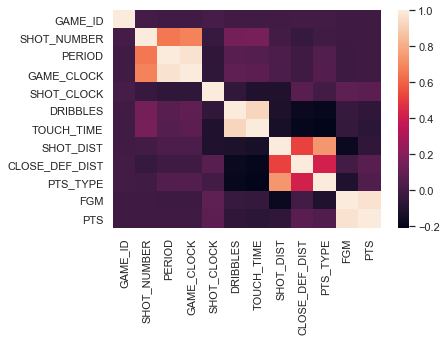

In [34]:
sns.heatmap(df.corr());

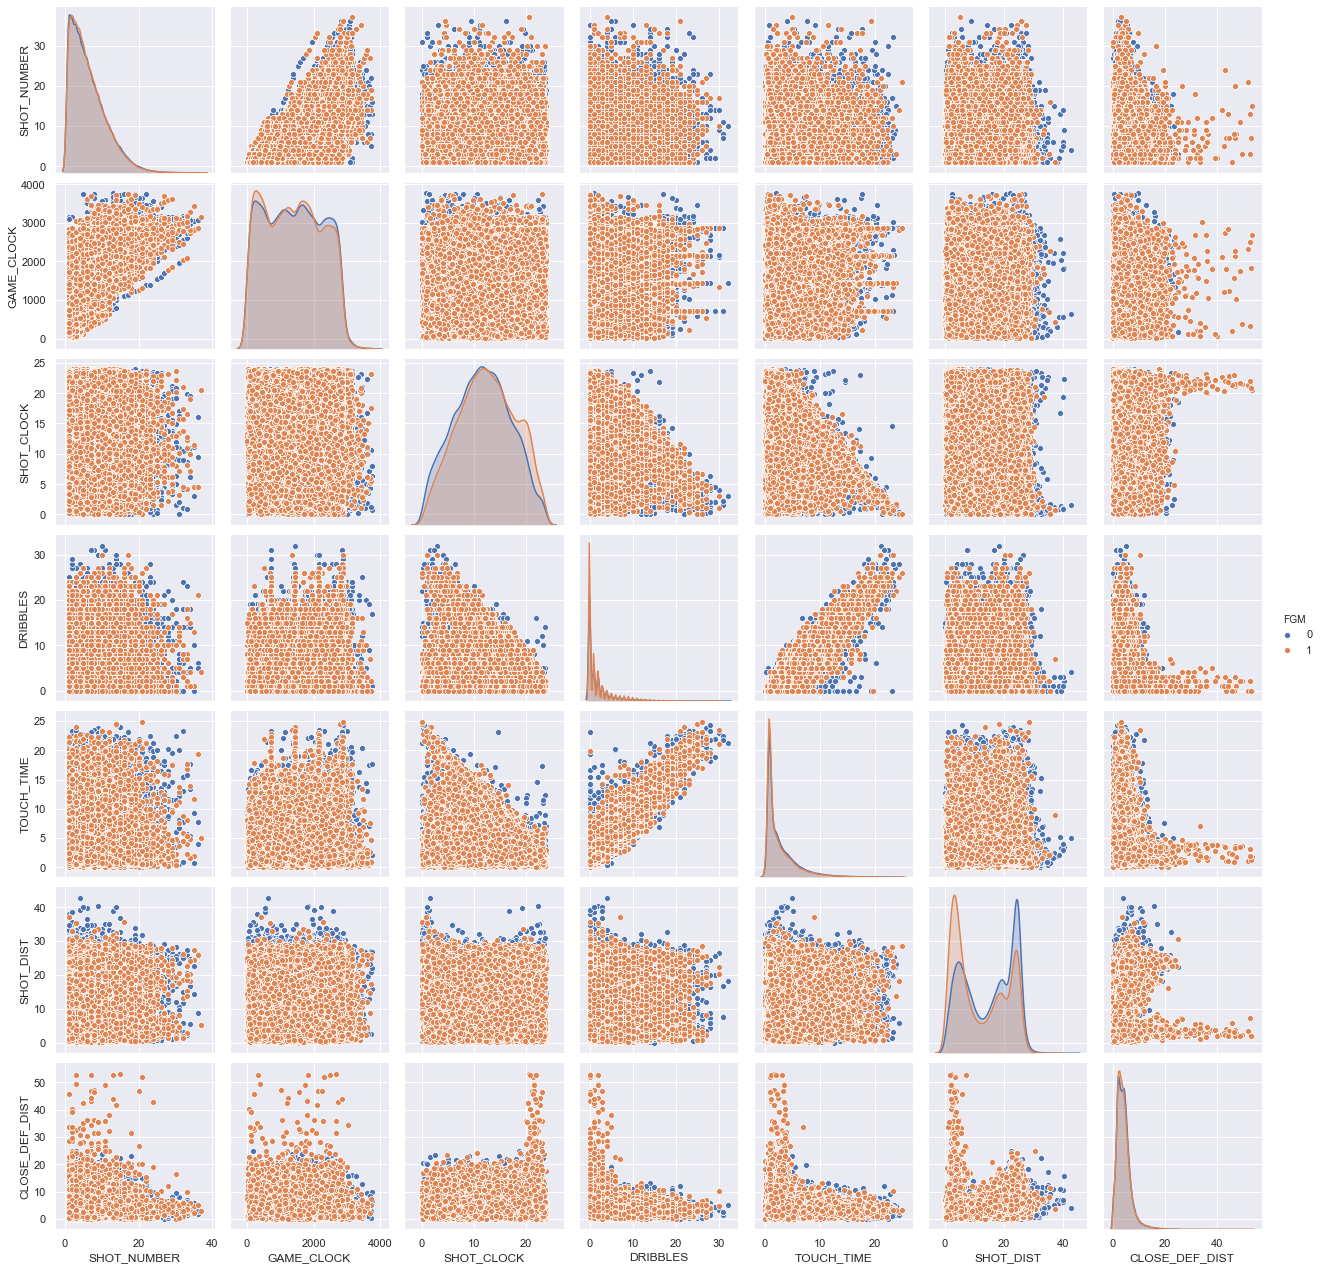

In [35]:
sns.pairplot(df[['SHOT_NUMBER', 'GAME_CLOCK', 'SHOT_CLOCK','DRIBBLES',
                  'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST','FGM']], hue='FGM');

''

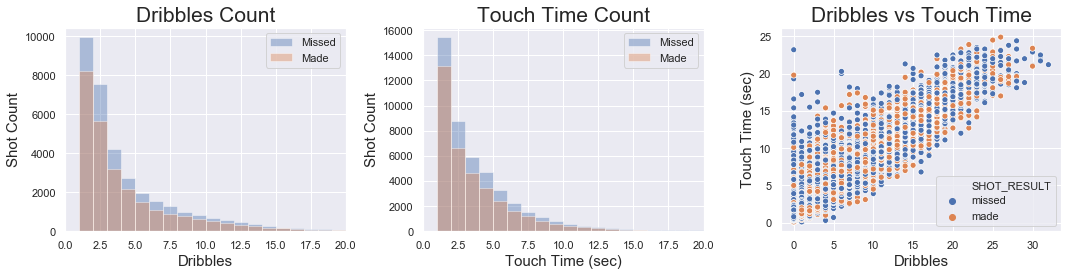

In [36]:
# Graphs for Dribbles and Touch Time
fig, axs = plt.subplots(1,3,figsize=(15,4))
axs.flatten()

(sns.distplot(miss.DRIBBLES, bins=np.arange(1, 100, 1), ax=axs[0], label='Missed', kde=False))
(sns.distplot(made.DRIBBLES, bins=np.arange(1, 100, 1), ax=axs[0], label='Made', kde=False)
    .set_title("Dribbles Count",fontsize=21))

(sns.distplot(miss.TOUCH_TIME, bins=np.arange(1, 100, 1), ax=axs[1], label='Missed', kde=False))
(sns.distplot(made.TOUCH_TIME, bins=np.arange(1, 100, 1), ax=axs[1], label='Made', kde=False)
    .set_title("Touch Time Count",fontsize=21))

(sns.scatterplot(x='DRIBBLES',y='TOUCH_TIME', data=df, ax=axs[2],
                 hue='SHOT_RESULT', hue_order=['missed','made'])
                .set_title("Dribbles vs Touch Time",fontsize=21))

axs[0].set_xlabel('Dribbles',fontsize=15)
axs[0].set_ylabel('Shot Count',fontsize=15)
axs[1].set_xlabel('Touch Time (sec)',fontsize=15)
axs[1].set_ylabel('Shot Count',fontsize=15)

axs[2].set_xlabel('Dribbles',fontsize=15)
axs[2].set_ylabel('Touch Time (sec)',fontsize=15)

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)


axs[0].legend()
axs[1].legend()
axs[2].legend()

fig.tight_layout()
;
#plt.savefig('images/dribblesvstouchtime.png')

''

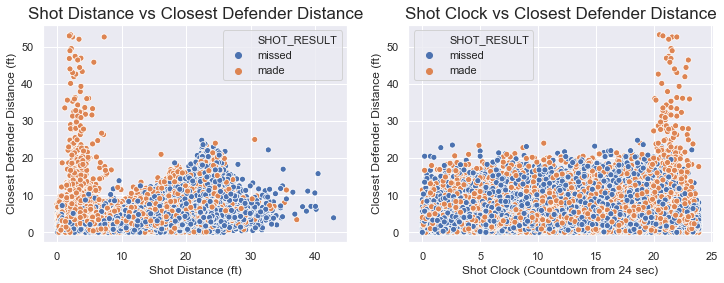

In [37]:
# Graph of Shot and Defender Distance and Graph of Shot Clock and Defender Distance
fig,axs = plt.subplots(1,2, figsize=(12,4))
axs.flatten()

sns.scatterplot(x='SHOT_DIST',y='CLOSE_DEF_DIST', data=df, ax=axs[0],
                hue='SHOT_RESULT', hue_order=['missed','made'])

axs[0].set_xlabel('Shot Distance (ft)')
axs[0].set_ylabel('Closest Defender Distance (ft)')
axs[0].set_title('Shot Distance vs Closest Defender Distance',fontsize=17)

sns.scatterplot(x='SHOT_CLOCK',y='CLOSE_DEF_DIST', data=df, ax=axs[1],
                hue='SHOT_RESULT', hue_order=['missed','made'])

axs[1].set_xlabel('Shot Clock (Countdown from 24 sec)')
axs[1].set_ylabel('Closest Defender Distance (ft)')
axs[1].set_title('Shot Clock vs Closest Defender Distance',fontsize=17)

;
#plt.savefig('images/defdistscatter.png')

''

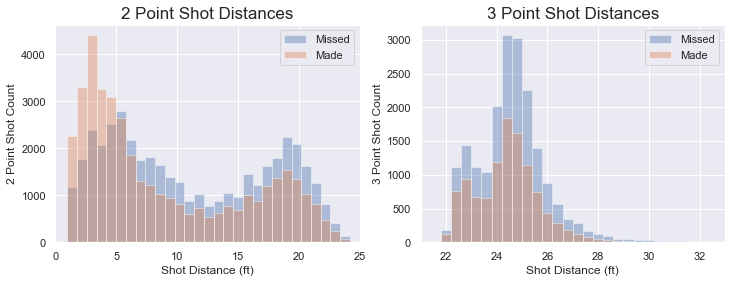

In [38]:
# Graphs for 2 and 3 Point Shot Distances
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.SHOT_DIST, bins=np.arange(1, 100, .8), ax=axs[0], label='Missed', kde=False))
(sns.distplot(madetwo.SHOT_DIST, bins=np.arange(1, 100, .8), ax=axs[0], label='Made', kde=False)
    .set_title("2 Point Shot Distances",fontsize=17))

(sns.distplot(missthree.SHOT_DIST, bins=np.arange(1, 100, 0.4), ax=axs[1], label='Missed', kde=False))
(sns.distplot(madethree.SHOT_DIST, bins=np.arange(1, 100, 0.4), ax=axs[1], label='Made', kde=False)
    .set_title("3 Point Shot Distances",fontsize=17))

axs[0].set_xlabel('Shot Distance (ft)')
axs[0].set_ylabel('2 Point Shot Count')
axs[1].set_xlabel('Shot Distance (ft)')
axs[1].set_ylabel('3 Point Shot Count')

axs[0].set_xlim(0,25)
axs[1].set_xlim(21,33)

axs[0].legend()
axs[1].legend()
;
#plt.savefig('images/shotdisthist.png')

*Shot clock counts down from 24.0 seconds


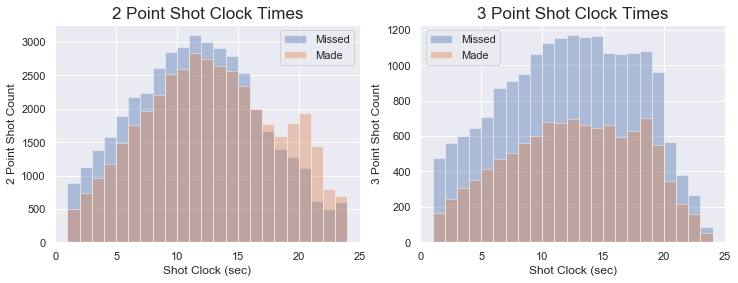

In [39]:
# Graphs for 2 and 3 Point Shot Clock Times
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.SHOT_CLOCK, ax=axs[0], bins=range(1, 100, 1), label='Missed', kde=False))
(sns.distplot(madetwo.SHOT_CLOCK, ax=axs[0], bins=range(1, 100, 1), label='Made', kde=False)
    .set_title("2 Point Shot Clock Times",fontsize=17))

(sns.distplot(missthree.SHOT_CLOCK, ax=axs[1], bins=range(1, 100, 1), label='Missed', kde=False))
(sns.distplot(madethree.SHOT_CLOCK, ax=axs[1], bins=range(1, 100, 1), label='Made', kde=False)
    .set_title("3 Point Shot Clock Times",fontsize=17))

axs[0].set_xlabel('Shot Clock (sec)')
axs[0].set_ylabel('2 Point Shot Count')
axs[1].set_xlabel('Shot Clock (sec)')
axs[1].set_ylabel('3 Point Shot Count')

axs[0].set_xlim(0,25)
axs[1].set_xlim(0,25)

axs[0].legend()
axs[1].legend()
;

print('*Shot clock counts down from 24.0 seconds')
#plt.savefig('images/shotclockhist.png')

''

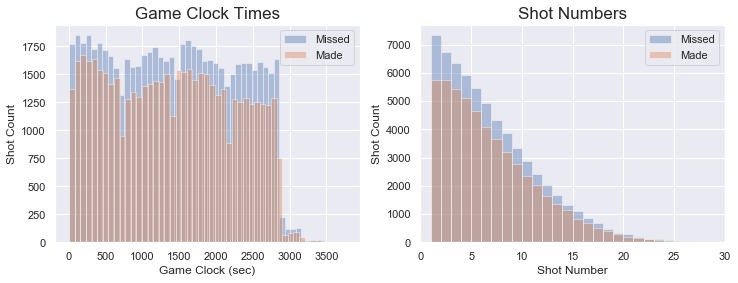

In [40]:
# Graphs for Game Clock Times and Shot Numbers
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(miss.GAME_CLOCK, ax=axs[0], label='Missed', kde=False))
(sns.distplot(made.GAME_CLOCK, ax=axs[0], label='Made', kde=False)
    .set_title("Game Clock Times",fontsize=17))

(sns.distplot(miss.SHOT_NUMBER, bins=np.arange(1, 100, 1), ax=axs[1], label='Missed', kde=False))
(sns.distplot(made.SHOT_NUMBER, bins=np.arange(1, 100, 1), ax=axs[1], label='Made', kde=False)
    .set_title("Shot Numbers",fontsize=17))

axs[0].set_xlabel('Game Clock (sec)')
axs[0].set_ylabel('Shot Count')
axs[1].set_xlabel('Shot Number')
axs[1].set_ylabel('Shot Count')

axs[1].set_xlim(0,30)

axs[0].legend()
axs[1].legend()
;

*152 shots (0.13%) with a defender 20 ft away (caps at 53 ft), NBA court is 94 by 50 feet


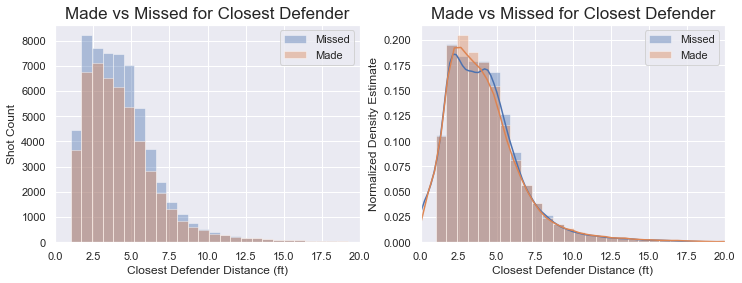

In [41]:
# Graphs for Made and Missed Shots for Closest Defender
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(miss.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[0], label='Missed', kde=False))
(sns.distplot(made.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[0], label='Made', kde=False)
    .set_title("Made vs Missed for Closest Defender",fontsize=17))

(sns.distplot(miss.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[1], label='Missed'))
(sns.distplot(made.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[1], label='Made')
    .set_title("Made vs Missed for Closest Defender",fontsize=17))

axs[0].set_xlabel('Closest Defender Distance (ft)')
axs[0].set_ylabel('Shot Count')
axs[1].set_xlabel('Closest Defender Distance (ft)')
axs[1].set_ylabel('Normalized Density Estimate')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)


axs[0].legend()
axs[1].legend()
;
print('*152 shots (0.13%) with a defender 20 ft away (caps at 53 ft), NBA court is 94 by 50 feet')

''

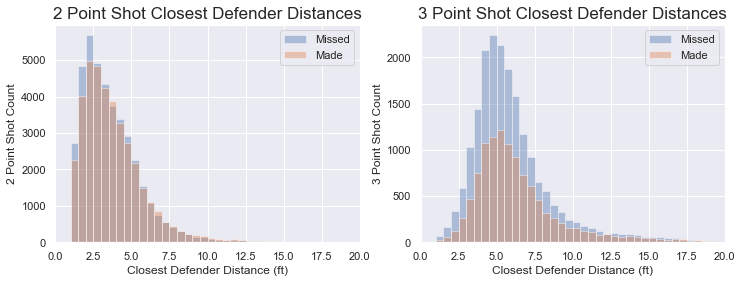

In [42]:
# Graphs for 2 and 3 Point Shots for Closest Defender Distances
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Missed', kde=False))
(sns.distplot(madetwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Made', kde=False)
    .set_title("2 Point Shot Closest Defender Distances",fontsize=17))

(sns.distplot(missthree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Missed', kde=False))
(sns.distplot(madethree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Made', kde=False)
    .set_title("3 Point Shot Closest Defender Distances",fontsize=17))

axs[0].set_xlabel('Closest Defender Distance (ft)')
axs[0].set_ylabel('2 Point Shot Count')
axs[1].set_xlabel('Closest Defender Distance (ft)')
axs[1].set_ylabel('3 Point Shot Count')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)

axs[0].legend()
axs[1].legend()
;
#plt.savefig("images/twothreedefdist.png")

''

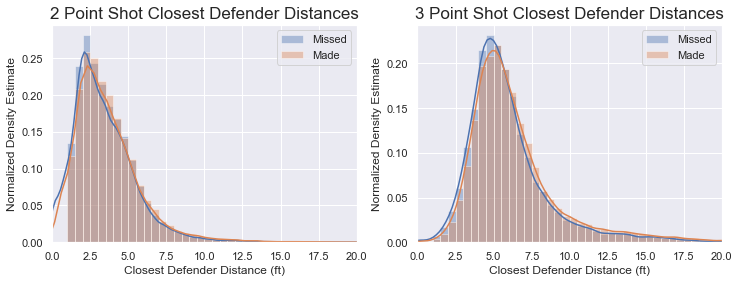

In [43]:
# Graphs for 2 and 3 Point Shots for Closest Defender KDE
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Missed'))
(sns.distplot(madetwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Made')
    .set_title("2 Point Shot Closest Defender Distances",fontsize=17))

(sns.distplot(missthree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Missed'))
(sns.distplot(madethree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Made')
    .set_title("3 Point Shot Closest Defender Distances",fontsize=17))

axs[0].set_xlabel('Closest Defender Distance (ft)')
axs[0].set_ylabel('Normalized Density Estimate')
axs[1].set_xlabel('Closest Defender Distance (ft)')
axs[1].set_ylabel('Normalized Density Estimate')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)

axs[0].legend()
axs[1].legend()
;

### Hypothesis Testing

In [134]:
made2CDD = madetwo[madetwo.CLOSE_DEF_DIST < 20].CLOSE_DEF_DIST
miss2CDD = misstwo[misstwo.CLOSE_DEF_DIST < 20].CLOSE_DEF_DIST
made3CDD = madethree[madethree.CLOSE_DEF_DIST < 20].CLOSE_DEF_DIST
miss3CDD = missthree[missthree.CLOSE_DEF_DIST < 20].CLOSE_DEF_DIST

**The U-Test for 3 Point Shot Closest Defender Distance**  
To test the hypothesis that closest defender distance is a factor in the shot outcome, we need to adopt a Null hypothesis.  The Null for the Mann–Whitney test is directly related to if a made or missed shot has a greater closest defender distance.

> $H_0$: The distance of the closest defender for missed two or three point shots are equally likely to be higher than for made shots as the other way around; i.e., 
  
  $$P(\text{ Missed 2 or 3 Defender Distance} > \text{Made 2 or 3 Defender Distance }) = 0.5$$
  
As is usual, assuming this null hypothesis is true, the rank-sum statistic assumes a known (but complicated) distribution.  This time we can't write down the distribution in any explicit way, but python can calculate p-values using it.

In [135]:
stats.mannwhitneyu(made2CDD, miss2CDD, alternative='greater')

MannwhitneyuResult(statistic=939613922.5, pvalue=4.188683331600985e-32)

In [136]:
stats.mannwhitneyu(made3CDD, miss3CDD, alternative='greater')

MannwhitneyuResult(statistic=114420545.0, pvalue=5.181917770120012e-32)

**p-value for missed 2 def dist > made 2 def dist was 4.2e-32.**  
The closest defender distance for a made 2 point shot is clearly greater than for a missed shot.

**p-value for missed 3 def dist > made 3 def dist was 5.2e-32.**  
The closest defender distance for a made 3 point shot is clearly greater than for a missed shot.